$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

# A2 Adam vs SGD

Abigail Rictor

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd  # for display and clear_output
import time  # for sleep

Let's create a long vector of all of the weights in both layers.  Then we can define the weight matrix for each layer as views into this vector.  This allows us to take steps down the gradient of the error function by incrementing the whole weight vector.

Spend a little time understanding the difference between numpy views and copies.  [Here is a good tutorial](http://www.jessicayung.com/numpy-views-vs-copies-avoiding-costly-mistakes/).

In [2]:
def make_weights(shapes):
    '''make_weights(shape): weights is list of pairs of (n_inputs, n_units) for each layer.
    n_inputs includes the constant 1 input.
    Returns weight vector w of all weights, and list of matrix views into w for each layer'''
    # Make list of number of weights in each layer
    n_weights_each_matrix = [sh[0] * sh[1] for sh in shapes]
    # Total number of weights
    n_weights = sum(n_weights_each_matrix)
    # Allocate weight vector with component for each weight
    w = np.zeros(n_weights)
    # List Ws will be list of weight matrix views into w for each layer
    Ws = make_views_on_weights(w, shapes)
    return w, Ws    

In [3]:
def make_views_on_weights(w, shapes):    
    Ws = []
    first = 0
    for sh in shapes:
        # Create new view of w[first:last]
        last = first + sh[0] * sh[1]
        # Create new view of w[first:last] as matrix W to be matrix for a layer
        W = w[first:last].reshape(sh)
        # Initialize weight values to small uniformly-distributed values
        n_inputs = sh[0]
        scale = 1.0 / np.sqrt(n_inputs)
        W[:] = np.random.uniform(-scale, scale, size=sh)
        # Add to list of W matrices, Ws.
        Ws.append(W)
        first = last
    return Ws

In [4]:
# Set parameters of neural network
nHiddens = 10
nOutputs = 1

# Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
Vshape = (1 +1, nHiddens)
Wshape = (nHiddens + 1, nOutputs)
w, [V, W] = make_weights([Vshape, Wshape])

print('w\n', w)
print('V\n', V)
print('W\n', W)

w
 [ 0.39675016 -0.3571887   0.69474991 -0.28946352 -0.35505907 -0.0263303
 -0.03458548 -0.05931803  0.32868892  0.4272183  -0.26720863 -0.56647787
 -0.54335956  0.00345239  0.48151541 -0.24477155  0.64894793 -0.36087696
 -0.69324107  0.09934064  0.20000837  0.20301813  0.02072527 -0.09750033
 -0.295008    0.28621015 -0.14612745 -0.04207432  0.12301131 -0.2567274
  0.28496374]
V
 [[ 0.39675016 -0.3571887   0.69474991 -0.28946352 -0.35505907 -0.0263303
  -0.03458548 -0.05931803  0.32868892  0.4272183 ]
 [-0.26720863 -0.56647787 -0.54335956  0.00345239  0.48151541 -0.24477155
   0.64894793 -0.36087696 -0.69324107  0.09934064]]
W
 [[ 0.20000837]
 [ 0.20301813]
 [ 0.02072527]
 [-0.09750033]
 [-0.295008  ]
 [ 0.28621015]
 [-0.14612745]
 [-0.04207432]
 [ 0.12301131]
 [-0.2567274 ]
 [ 0.28496374]]


Now for some functions for calculating the output of our network, and for backpropagating the error to get a gradient of error with respect to all weights.

In [5]:
def forward(Ws, X1):
    # Forward pass on training data
    V, W = Ws
    Z = np.tanh(X1 @ V)
    Z1 = np.insert(Z, 0, 1, 1)
    Y = Z1 @ W
    return Z1, Y

In [6]:
def backward(w, Ws, X1, Z1, T, error):
    V, W = Ws
    # Backward pass. 
    # Calculate the gradient of squared error with respect to all weights in w.
    #   Order of in w is all hidden layer weights followed by all output layer weights,
    #   so gradient values are ordered this way.
    gradient =  np.hstack(((- X1.T @ ( ( error @ W[1:, :].T) * (1 - Z1[:, 1:]**2))).flat,  # for hidden layer
                          (- Z1.T @ error).flat))  # for output layer
    return gradient

Given these functions, we can now define the stochastic gradient descent, `sgd`, procedure to update the weights.

In [7]:
def sgd_init():
    pass

def sgd(w, Ws, X1, T, learning_rate):
    Z1, Y = forward(Ws, X1)

    # Error in output
    n_samples = X1.shape[0]
    n_outputs = T.shape[1]
    
    error = (T - Y) / (n_samples + n_outputs)

    gradient = backward(w, Ws, X1, Z1, T, error)
   
    # update values of w, in place. Don't need to return it.
    
    w -= learning_rate * gradient

Here is another way to update the weights, the `adam` procedure.  See [this discussion](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) of Adam and other gradient descent methods.

In [8]:
grad_trace = 0
grad_squared_trace = 0
update_step = 0

def adam_init():
    global grad_trace, grad_squared_trace, update_step

    grad_trace = 0
    grad_squared_trace = 0
    update_step = 0
    
def adam(w, Ws, X1, T, learning_rate):
    global grad_trace, grad_squared_trace, update_step

    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    Z1, Y = forward(Ws, X1)

    # Error in output
    error = T - Y

    gradient = backward(w, Ws, X1, Z1, T, error)
    
    # approximate first and second moment
    grad_trace = beta1 * grad_trace + (1 - beta1) * gradient
    grad_squared_trace = beta2 * grad_squared_trace + (1 - beta2) * np.square(gradient)
    
    # bias corrected moment estimates
    grad_hat = grad_trace / (1 - beta1 ** (update_step + 1) )
    grad_squared_hat = grad_squared_trace / (1 - beta2 ** (update_step + 1) )
                
    dw = grad_hat / (np.sqrt(grad_squared_hat) + epsilon)
    
    n_samples = X1.shape[0]
    n_outputs = T.shape[1]
    
    # update values of w, in place. Don't need to return it.
    w -= learning_rate / (n_samples + n_outputs) * dw
    
    update_step += 1

Now, wrap these all together into a function to train a neural network given the training and testing data, the gradient descent function names, the batch size, the number of epochs, the learning rate, and the graphics update rate.

In [9]:
def train(Xtrain, Ttrain, Xtest, Ttest,
          n_hiddens, 
          gradient_descent_method_init, gradient_descent_method, 
          batch_size, n_epochs, learning_rate, graphics_rate=0):

    if graphics_rate > 0 and Xtrain.shape[1] > 1:
        print('Graphics only works when X has one column (data has one input variable)')
        print('Setting graphics_rate to 0')
        graphics_rate = 0
    
    # Initialize weights to uniformly distributed values between small normally-distributed between -0.1 and 0.1
    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]
    Vshape = (1 + n_inputs, n_hiddens)
    Wshape = (1 + n_hiddens, n_outputs)
    w, [V, W] = make_weights([Vshape, Wshape])

    error_trace = np.zeros((n_epochs, 2))

    if graphics_rate > 0:
        fig = plt.figure(figsize=(12, 10))
        
    Xtrain1 = np.insert(Xtrain, 0, 1, 1)
    Xtest1 = np.insert(Xtest, 0, 1, 1)
    n_samples = Xtrain1.shape[0]
        
    gradient_descent_method_init()
    
    for epoch in range(n_epochs):

        # gradient_descent_method_init()
        
        # Reorder samples
        rows = np.arange(n_samples)
        np.random.shuffle(rows)
        
        for first_n in range(0, n_samples, batch_size):
            last_n = first_n + batch_size
            rows_batch = rows[first_n:last_n]
            Xtrain1_batch = Xtrain1[rows_batch, :]
            Ttrain_batch = Ttrain[rows_batch, :]
            # gradient_descent method changes values of w
            gradient_descent_method(w, [V, W], Xtrain1_batch, Ttrain_batch, learning_rate)
    
        # error traces for plotting
        Z1train, Ytrain = forward([V, W], Xtrain1)
        error_trace[epoch, 0] = np.sqrt(np.mean(((Ttrain - Ytrain)**2)))
    
        Z1test, Ytest = forward([V, W], Xtest1)
        error_trace[epoch, 1] = np.sqrt(np.mean((Ytest - Ttest)**2))

        if graphics_rate > 0 and (epoch % graphics_rate == 0 or epoch == n_epochs - 1):
            plt.clf()
            plt.subplot(3, 1, 1)
            plt.plot(error_trace[:epoch, :])
            plt.ylim(0, 0.4)
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.legend(('Train','Test'), loc='upper left')
        
            plt.subplot(3, 1, 2)
            plt.plot(Xtrain, Ttrain, 'o-', Xtest, Ttest, 'o-', Xtrain, Ytrain, 'o-')
            plt.xlim(-1, 1)
            plt.ylim(-0.2, 1.6)
            plt.legend(('Training', 'Testing', 'Model'), loc='upper left')
            plt.xlabel('$x$')
            plt.ylabel('Actual and Predicted $f(x)$')
        
            plt.subplot(3, 1, 3)
            plt.plot(Xtrain, Z1train[:, 1:])  # Don't plot the constant 1 column
            plt.ylim(-1.1, 1.1)
            plt.xlabel('$x$')
            plt.ylabel('Hidden Unit Outputs ($z$)');
        
            ipd.clear_output(wait=True)
            ipd.display(fig)

    ipd.clear_output(wait=True)

    return Ytrain, Ytest, error_trace

Here are some demonstrations.

In [10]:
# Make some training data
n = 20
Xtrain = np.linspace(0.,20.0,n).reshape((n,1)) - 10
Ttrain = 0.2 + 0.05 * (Xtrain + 10) + 0.4 * np.sin(Xtrain + 10) + 0.2 * np.sin(Xtrain * 3) + 0.01 * np.random.normal(size=(n, 1))
Xtrain = Xtrain / 10

# Make some testing data
n = n // 3
Xtest = np.linspace(0, 20, n).reshape((-1, 1)) - 10
Ttest = 0.2 + 0.05 * (Xtest + 10) + 0.2 * np.sin(Xtest + 10) +  0.1 * np.sin(Xtest * 3) + 0.01 * np.random.normal(size=(n, 1))
Xtest = Xtest / 10

In [79]:
Ytrain, Ytest, error_trace = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=sgd_init, gradient_descent_method=sgd,
                       batch_size=Xtrain.shape[0], n_epochs=200000, learning_rate=0.2, graphics_rate=5000)
print('Final RMSE', np.sqrt(np.mean((Ttest - Ytest)**2)))

Final RMSE nan


In [ ]:
Ytrain, Ytest, error_trace = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=adam_init, gradient_descent_method=adam,
                       batch_size=Xtrain.shape[0], n_epochs=100000, learning_rate=0.05, graphics_rate=5000)
print('Final RMSE', np.sqrt(np.mean((Ttest - Ytest)**2)))

SGD 0.13628625267906064 Adam 0.13908045168516606


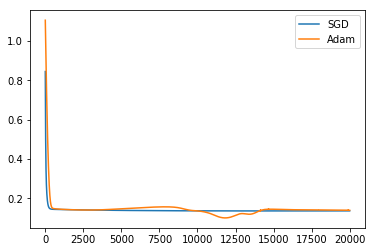

In [12]:
n_samples = Xtrain.shape[0]

_, _, error_trace_adam = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=adam_init, gradient_descent_method=adam,
                       batch_size=n_samples, n_epochs=20000, learning_rate=0.01, graphics_rate=0)

_, _, error_trace_sgd = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                       gradient_descent_method_init=sgd_init, gradient_descent_method=sgd,
                       batch_size=n_samples, n_epochs=20000, learning_rate=0.01, graphics_rate=0)

plt.plot(np.hstack((error_trace_sgd[:, 1:], error_trace_adam[:, 1:])))
plt.legend(('SGD', 'Adam'))

print('SGD', error_trace_sgd[-1, 1], 'Adam', error_trace_adam[-1, 1])

# Search for Good Parameter Values on a New Data Set

Now your work begins.  First, download this [Real Estate Valuation Data](https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set) from the UCI machine learning repository. Read it in to python and form an input matrix `X` that contains six columns, and target matrix `T` of one column containing the house price of unit area.  This is easiest to do with the [pandas](https://pandas.pydata.org/) package.  Check out the [Getting Started](http://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html) material at the pandas site.  Near the bottom of that page are some simple examples of how to use the `read_excel` pandas function.  Pretty handy since the Real Estate data is an `.xlsx` file.  Other helpful functions are the `drop` function that can be used to remove a column, such as the one labeled `No` in the data file, which is just an index that we should ignore, and `data.columns.tolist()` where `data` is a Dataframe.  Also note that a Dataframe can be converted to a `numpy` array by `npdata = np.array(data)` where `data` again is a Dataframe.

We want to try to predict the target value from the six input values.

Randomly partition the data into an 80% partition for training, making `Xtrain` and `Ttrain`, and a 20% partition for testing, makng `Xtest` and `Ttest`.

Standardize the input `Xtrain` and `Xtest` matrices by subtracting by the column means and dividing by the column standard deviations, with the means and standard deviations determined only from the `Xtrain` matrix.

In [13]:
import pandas as pd
import numpy as np

In [47]:
def partition(data):
    data_copy = np.random.permutation(data)
    division_index = int(.8*len(data_copy))
    training = data_copy[:division_index]
    testing = data_copy[division_index:]               
    return training, testing

def separate_targets(data):
    X = data[:, :data.shape[1]-1]
    T = data[:,data.shape[1]-1:data.shape[1]]
    return X, T

In [48]:
data = pd.read_excel('data.xlsx', 'Sheet1', index_col=None, na_values=['NA']).drop("No", axis=1)
npdata = np.array(data)
training, testing = partition(npdata)
Xtrain, Ttrain = separate_targets(training)
Xtest, Ttest = separate_targets(testing)

Using the one-hidden layer neural network implemented here, train neural networks in two ways: one with SGD and one with Adam.  For each, try at least three values for each of the following parameters:

  * number of hidden units, from 1 to 50,
  * batch size,
  * number of epochs
  * learning_rate

Create a table of results containing the algorithm name ('sgd' or 'adam'), the values of the above four parameters, and the RMSE on the training and testing data.  Since this is a mixed-type table, use the `pandas` package.  Sort your table by the test RMSE. 

Here are some clues on how to do this. To initialize a `pandas` Dataframe, called `results` do

      import pandas as pd
      
      results = pd.DataFrame(columns=['Algorithm', 'Epochs', 'Learning Rate', 'Hidden Units', 'Batch Size', 
                                'RMSE Train', 'RMSE Test'])
To add a row to this, do

      results.loc[len(results)] = [algo, n_epochs, lr, nh, bs, rmse(Ytrain, Ttrain), rmse(Ytest, Ttest)]
      
assuming those variables have appropriate values.  Then, to sort `results` by `RMSE Test` and just see the top 50 entries, do

      results.sort_values('RMSE Test').head(50)

In [16]:
def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

In [50]:
def run_parameters(Xtrain, Ttrain, Xtest, Ttest, epoch_list, learning_rate_list, hidden_unit_list, batch_size_list, verbose=False):
    results = pd.DataFrame(columns=['Algorithm', 'Epochs', 'Learning Rate', 'Hidden Units', 'Batch Size', 
                            'RMSE Train', 'RMSE Test'])
    for algorithm in ['adam', 'sgd']:
        init = adam_init if algorithm is 'adam' else sgd_init
        method = adam if algorithm is 'adam' else sgd
        for epoch in epoch_list:
            for learning_rate in learning_rate_list:
                for hidden_units in hidden_unit_list:
                    for batch_size in batch_size_list:
                        Ytrain, Ytest, error_trace = train(Xtrain, Ttrain, Xtest, Ttest, n_hiddens=20, 
                                               gradient_descent_method_init=init, gradient_descent_method=method,
                                               batch_size=batch_size, n_epochs=epoch, learning_rate=learning_rate, graphics_rate=0)
                        results.loc[len(results)] = [algorithm, epoch, learning_rate, hidden_units, batch_size, rmse(Ytrain, Ttrain), rmse(Ytest, Ttest)]
                    
    return results

In [51]:
data = np.loadtxt('machine.data', delimiter=',', usecols=range(2, 10))
X = data[:, :-2]
T = data[:, -2:-1]
Xtrain = X[:160, :]
Ttrain = T[:160, :]
Xtest = X[160:, :]
Ttest = T[160:, :]

means = Xtrain.mean(0)
stds = Xtrain.std(0)
Xtrains = (Xtrain - means) / stds
Xtests = (Xtest - means) / stds

Put the above steps into a new function named `run_parameters` that accepts the arguments

    * Xtrain, standardized
    * Ttrain
    * Xtest, standardized
    * Ttest
    * list of numbers of epochs
    * list of learning rates
    * list of numbers of hidden units
    * list of batch sizes
    * verbose, if True then print results of each parameter value combination

and returns a pandas DataFrame containing the results of runs for all combinations of the above parameter values. The DataFrame must have columns titled `[Algorithm', 'Epochs', 'Learning Rate', 'Hidden Units', 'Batch Size', 'RMSE Train', 'RMSE Test']`.  So, if eac of the above lists contains two values, the resulting DataFrame must have 16 rows.

Describe your experiments, including how you decided on what values to test, and what the results tell you.  

Extract the `RMSE test` values for all values of `Hidden Units` using the best values for the other parameters.  Here is an example of how to do this.

    nh =results.loc[(results['Algorithm'] == 'adam') & (results['Epochs'] == 100) &
                    (results['Learning Rate'] == 0.002) & (results['Batch Size'] == 1)]
                    
Now you can plot the training and testing RMSE versus the hidden units.  Describe what you see.

In [84]:
results = run_parameters(Xtrains, Ttrain, Xtests, Ttest, [100, 1000, 5000], [0.01, 0.05, .1], [1, 25, 50], [25, 50, 75], verbose=False)
nh = results.loc[(results['Algorithm'] == 'adam') & (results['Epochs'] == 100) &
                (results['Learning Rate'] == 0.001) & (results['Batch Size'] == 1)]

I used the following values in my test run.

epochs: 100, 500, 1000

learning rates: .01, .05, .1 

hidden units: 1, 25, 50

batch sizes: 25, 50, 75

My intention has been to gather data for a great range of potential values for each input, though my epoch counts are admittedly low (this is from a practical standpoint).

Below are the ten best RMSE Test values from this run, showing 'sgd' as the prevailing algorithm in this context. There are also plots showing the RMSE Train (orange) and Test (green) values in comparison to the number of hidden units (blue) in a test with 1000 epochs, a batch size of 25, and a learning rate controlled values. I've included one for the sgd algorithm (top) and one for the adam algorithm (bottom).

,Algorithm,Epochs,Learning Rate,Hidden Units,Batch Size,RMSE Train,RMSE Test
147,sgd,5000,0.05,25,25,63.993655,71.832304
145,sgd,5000,0.05,1,50,54.540165,97.332165
153,sgd,5000,0.10,1,25,58.821608,106.733553
128,sgd,1000,0.10,1,75,62.889458,113.785541
149,sgd,5000,0.05,25,75,73.160386,130.998412
91,sgd,100,0.05,1,50,75.256448,136.827544
89,sgd,100,0.01,50,75,72.019764,138.369906
138,sgd,5000,0.01,25,25,76.171356,140.245510
110,sgd,1000,0.01,1,75,68.443108,141.035347
86,sgd,100,0.01,25,75,72.866244,146.184433


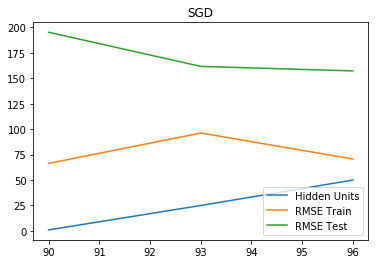

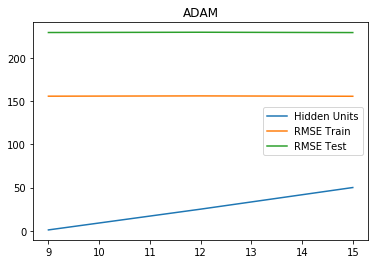

In [86]:
sgd_nh = results.loc[(results['Algorithm'] == 'sgd') & (results['Epochs'] == 100) &
                (results['Learning Rate'] == 0.05) & (results['Batch Size'] == 25)].drop("Epochs", axis=1).drop("Batch Size", axis=1).drop("Learning Rate", axis=1)

adam_nh = results.loc[(results['Algorithm'] == 'adam') & (results['Epochs'] == 100) &
                (results['Learning Rate'] == 0.05) & (results['Batch Size'] == 25)].drop("Epochs", axis=1).drop("Batch Size", axis=1).drop("Learning Rate", axis=1)

sgd_nh.plot(title="SGD")

adam_nh.plot(title="ADAM")

results.sort_values('RMSE Test').head(10)

The data above shows sgd to have more accurate results, and that those results are more accurate at the midpoint of possible hidden units values (25). This reflects what I know about the adam optimization algorithm, showing that using fewer epochs, sgd can be as effective or moreso (as seen here) than the optimization, which allows more effective training relative to the number of epochs, unlike sgd which flattens out at an earlier point.

## Grading

Download [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs445/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  You should see a perfect execution score of 90 out of 90 points if your functions are defined correctly. The remaining 10 points will be based on the results you obtain from the energy data and on your discussions.

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

A different, but similar, grading script will be used to grade your checked-in notebook.  It will include additional tests.  You need not include code to test that the values passed in to your functions are the correct form.

In [81]:
%run -i A2grader.py

   Algorithm Epochs  Learning Rate Hidden Units Batch Size  RMSE Train  \
0       adam     10          0.001            5          1  168.967265   
1       adam     10          0.001            5         50  172.501939   
2       adam     10          0.001           10          1  169.048043   
3       adam     10          0.001           10         50  172.682357   
4       adam     10          0.010            5          1  141.247677   
5       adam     10          0.010            5         50  172.689262   
6       adam     10          0.010           10          1  140.833241   
7       adam     10          0.010           10         50  172.667873   
8       adam    100          0.001            5          1  141.067645   
9       adam    100          0.001            5         50  172.605579   
10      adam    100          0.001           10          1  140.985064   
11      adam    100          0.001           10         50  172.467506   
12      adam    100          0.010    

<Figure size 432x288 with 0 Axes>

# Extra Credit

Repeat the evaluation of parameter values for another data set of your choice.